Takes 1 minute 40 seconds or so to run

In [1]:
import os
import re
import json
import pathlib
import numpy as np
import pandas as pd
import ast

print(f"Current directory: {os.getcwd()}")
path_dataset = pathlib.Path("../dataset/")

with open("ingredient_mapper.json", "r") as f:
    ingredient_mapper = json.load(f)

from zipfile import ZipFile
with ZipFile(path_dataset/"recipenlg-dataset.zip") as z:
    with z.open("dataset/full_dataset.csv") as f:
        df = pd.read_csv(f).drop(columns=['Unnamed: 0'])
df.ingredients = [ast.literal_eval(item.lower()) for item in df.ingredients]
df.NER = [ast.literal_eval(item.lower()) for item in df.NER]
df.NER = [list(set(item)) for item in df.NER] # list(set(...)) ensure NER lists are non-repetitive
df["source_website"] = [item.split(".com")[0].replace("www.", "") for item in df.link]

Current directory: /Users/longyyu/Documents/research/recipevis.git/src


## Keyword search to narrow down recipes

### Filter recipes of interest

* For example, pull chocolate chip cookie recipes with `patterns = ["cookie", "chocolate chip"]`
    - if `patterns = ["chocolate", "chip", "cookie"]` is used instead, there will be "peanut butter chip chocolate cookies" and "chocolate dipped potato chip cookies", which are not exactly CCC.
* Draw samples from the recipes grouped by source websites (source distributions are similar in the sample and in the entire collection)
* Peanut butter cookies: 5857 recipes (`patterns = ["peanut", "butter", "cookie"]`)

In [101]:
def filter_recipes(patterns, n=None, frac=None, random_seed=123):
    dft = df.loc[
        df.title.str.lower().apply(lambda item: all(pattern in item for pattern in patterns))
    ]\
        .reset_index(drop=True)\
        .drop(columns=["directions"])
    if n == None: # priortize sampling using "n" over "frac"
        if frac == None:
            raise Exception("'n' and 'frac' cannot both be None!")
        else:
            return dft.groupby("source_website").sample(frac=frac, random_state=random_seed)
    else:
        print(f"n={min([n, dft.shape[0]])}, dft has {dft.shape[0]} records")
        return dft.sample(n=min([n, dft.shape[0]]), random_state=random_seed) # no group by

def plot_source_dist(df):
    import matplotlib.pyplot as plt
    ax = df.groupby("source_website")["title"].count()\
        .sort_values(ascending=False)\
        .plot.bar(rot=40, figsize=[15,4]) # matplotlib.axes._subplots.AxesSubplot
    for bar in ax.patches:
        ax.annotate(bar.get_height(), (bar.get_x(), bar.get_height()))
    return ax

# helper function
def find_keyword(df, keyword):
    # input:
    #     df: has a column "NER" with each element being an iterable
    #     keyword: a search keyword
    # output: all records that have this keyword (exact match) in at least one of their NER item
    return [
        (i, [item for item in ner if keyword in item]) \
            for i, ner in enumerate(df.NER) \
                if any([keyword in item for item in ner])
    ]

n=150, dft has 2378 records
sj
(144, 7)


<AxesSubplot:xlabel='source_website'>

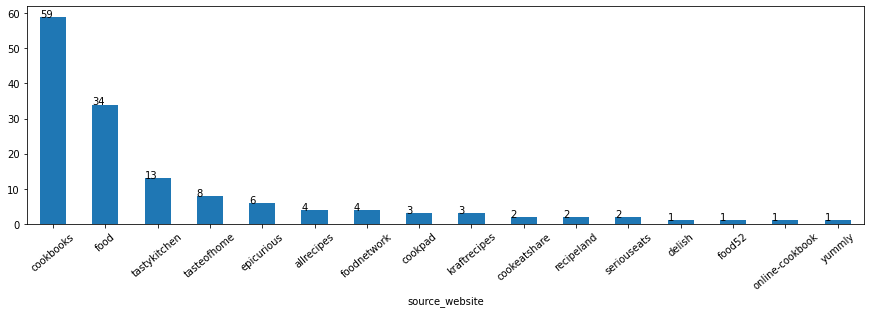

In [160]:
recipe_dataset = "sj" # "bc" for beef chili, "sj" for Sloppy Joes, "ccc" for chocolate chip cookies, "4desserts", and "others"

if recipe_dataset == "bc":
    df_output = filter_recipes(patterns=["beef", "chili"], n=150, random_seed=10000)\
        .assign(label="beef chili")\
        .reset_index(drop=True)

elif recipe_dataset == "sj":
    df_output = filter_recipes(patterns=["sloppy", "joe"], n=150, random_seed=10000)\
        .assign(label="sloppy joes")\
        .reset_index(drop=True)
    # drop any records with "%mix%" ingredients (e.g. sloppy joe mix, baking mix, etc.)
    df_output = df_output.drop([a for (a, b) in find_keyword(df_output, "mix")], axis=0).reset_index(drop=True)

elif recipe_dataset == "ccc":
    df_output = filter_recipes(patterns=["chocolate chip", "cookie"], frac=0.05, random_seed=10000)\
        .assign(label="chocolate chip cookie")\
        .reset_index(drop=True)

elif recipe_dataset == "4desserts":
    df_output = pd.concat([
        filter_recipes(patterns=["chocolate chip", "cookie"], frac=0.05, random_seed=10000).assign(label="chocolate chip cookie"),
        filter_recipes(patterns=["peanut", "butter", "cookie"], frac=0.05, random_seed=10086).assign(label="peanut butter cookie"),
        filter_recipes(patterns=["chocolate", "sheet", "cake"], frac=0.5, random_seed=1).assign(label="chocolate sheet cake"),
        filter_recipes(patterns=["chocolate", "brownie"], frac=.1, random_seed=48105).assign(label="chocolate brownie")
    ]).reset_index(drop=True)
    # drop rows with non-basic ingredients (cake/mix)
    rows_to_drop = [
        idx for idx, ner in enumerate(df_output.NER) \
            if [ingd for ingd in ner if re.findall("(mix|cake|cookies|cookie)$", ingd)]
    ]
    df_output = df_output.drop(rows_to_drop).reset_index(drop=True)

else: # others
    # ["baked", "bean"], frac=0.05
    # ["mac", "cheese"], frac=0.05
    # ["clam", "chowder"], frac=0.25
    # ["egg", "benedict"], frac=1
    # ["spinach", "pie"], frac=0.5
    # ["chicken", "tikka", "masala"], frac=1
    # ["dosa"], frac=1
    # ["lyonnaise", "potato"], n=300
    # ["po'", "boy"], n=300
    # ["lasagne"], n=300
    # ["shepherd", "pie"], n=300
    # ["samosa"], n=300
    # ["stargazy", "pie"], n=300
    # ["lobster", "bisque"]
    # ["coleslaw"]
    # ["beef", "chili"]]
    df_output = filter_recipes(patterns=["chowder"], n=300, random_seed=10000)#.assign(label="others")

print(recipe_dataset)
print(df_output.shape)
plot_source_dist(df_output)
# df_output.to_csv(path_dataset/f"recipenlg-{recipe_dataset}-to_clean_long.csv", index=False)

In [161]:
# find_keyword(df_output, "kidney") # this one will return row id
set(chain.from_iterable([b for (a, b) in find_keyword(df_output, "pork")]))

{'ground pork', 'pork'}

### Clean up NER list

* `ingredient_mapper.json`: full text match and swap
* `ner_replace_list`: partial match and swap
* `ner_drop_list`: messy NERs to take out
* With the ingredient frequency table, ingredient coappearance frequency table, and network graph, our goal is to examine the clean-up rules and adjust them accordingly
    - For example, using the network graph and adjusting the threshold of coappearance, I found out that "vanilla" appears when the threshold is very high (meaning it has a lot of coappearances with other major ingredients), while "vanilla extract" appears at a lower threshold. This reminds me that "vanilla" and "vanilla extract" might be the same thing and should be mapped to the same term. 

In [224]:
with open("ingredient_mapper.json", "r") as f:
    ingredient_mapper = json.load(f)

from collections import Counter
from itertools import combinations, chain

# some "ingredients" and "NER" columns have messy terms such as "+" or "ingredients"
# taking these out at this step
ner_drop_list = ["ingredients", "recipe", "packet", "choice", "flavorful", "extra-lean", "lean", "brown", "+", "½", "¼", "'s"]
ner_replace_list = [
    # chili/pepper
    ("chilis", "chili"), ("chilli", "chili"), ("chiles", "chili"), ("chilies", "chili"), ("chile", "chili"),
    ("red chili long", "long red chili"),
    ("peppers", "pepper"), ("chili pepper", "chili"),
    ("cracked black pepper", "black pepper"),
    # abbreviations
    ("pwdr", "powder"), ("grnd", "ground"),
    # stock/soup/bouillon
    ("beef stock condensed", "beef stock"), ("condensed beef broth", "beef broth"), 
    ("condensed chili beef soup", "beef broth"), ("broth powder", "broth"),
    ("beef bouillon", "beef broth"), ("beef broth granules", "beef broth"),
    ("campbell's chili beef soup", "beef broth"), ("chili beef soup", "beef broth"),
    # adjectives
    ("extra lean ", ""), ("extra-lean ", ""), ("lean ", ""), ("shredded ", ""),
    ("freshly ", ""), ("fresh ", ""), ("boneless ", ""), ("ground ", ""), ("cubed ", ""),
    (" roast", ""), ("tb ", ""), ("coarse ", ""), ("frozen ", ""), ("handful ", ""),
    # brand names
    ("campbell's ", ""),
    # beef cuts
    ("beef chuck steak", "beef"), ("beef chuck eye", "beef"), ("beef chuck", "beef"),
    ("beef sirloin steak", "beef"), ("beef sirloin", "beef"), ("beef brisket", "beef"),
    ("flank steak", "beef"), ("beef cube steak", "beef"), ("beef round steak", "beef"),
    ("beef tenderloin", "beef"), ("bottom round beef", "beef"), ("braising beef", "beef"),
    ("beef shoulder", "beef"), ("lean beef", "beef"), ("beef cubes", "beef"), ("beef mince", "beef"),
    ("sirloin beef", "beef"), ("beef flap", "beef"), ("beef loin", "beef"),
    ("beef short ribs", "beef"), ("beef skirt", "beef"), ("beef stew meat", "beef"), ("lean stew beef", "beef"),
    ("stewing beef", "beef"), ("corned beef", "beef"), ("lean beef", "beef"), ("beef brown", "beef"),
    # pork cuts
    ("pork shoulder", "pork"),
    # plural -> singular
    ("onions", "onion"), ("shallots", "shallot"), ("scallions", "scallion"), ("tomatoes", "tomato"), ("carrots", "carrot"),
    ("peanuts", "peanut"), ("eggs", "egg"), ("avocados", "avocado"), ("brown onion", "yellow onion"),
    # other random stuff
    ("catsup", "ketchup"), ("clove garlic", "garlic"), ("brown mustard spicy", "brown mustard"),
    ("pickle slices", "pickle"), ("flat leaf parsley", "parsley"), ("carrot regular", "carrot"), 
    ("dark red kidney beans", "kidney beans"), ("light kidney beans", "kidney beans"), ("red kidney beans", "kidney beans"),
    ("passata", "tomato paste")
]

def transform_ner(item):
    item = ingredient_mapper.get(item, item)
    for r in ner_replace_list:
        item = item.replace(*r)
    return item.strip()

df_output.NER = df_output.NER.apply(lambda ner : list(
    set([transform_ner(item) for item in ner])\
        .difference(ner_drop_list)
))

df_ingredients = pd.Series(chain.from_iterable(df_output.NER)).value_counts()\
    .rename("freq").reset_index().rename(columns={'index': 'ingredient'})
df_ingredients["freq_pct"] = df_ingredients.freq.apply(
    lambda x : "{:6.2f}%".format(x / df_output.shape[0] * 100)
)
ingd2count = dict(zip(df_ingredients.ingredient, df_ingredients.freq))

print(df_ingredients.shape)
print(df_ingredients.head(20))

(226, 3)
              ingredient  freq freq_pct
0                  onion   103   71.53%
1                   beef    87   60.42%
2                ketchup    74   51.39%
3                   salt    64   44.44%
4   worcestershire sauce    54   37.50%
5            brown sugar    52   36.11%
6                 garlic    46   31.94%
7                mustard    41   28.47%
8                   buns    38   26.39%
9                  water    36   25.00%
10          chili powder    31   21.53%
11          tomato sauce    30   20.83%
12                celery    27   18.75%
13               vinegar    25   17.36%
14          green pepper    24   16.67%
15             hamburger    23   15.97%
16                pepper    21   14.58%
17             olive oil    17   11.81%
18          tomato paste    17   11.81%
19        barbecue sauce    16   11.11%


In [223]:
# find_keyword(df_output, "chicken gumbo") # partial match, return row id
# [i for (i, ner) in enumerate(df_output.NER) if "chicken gumbo" in ner] # full text match, return row id
set(chain.from_iterable([b for (a, b) in find_keyword(df_output, "gumbo")]))
# chicken gumbo

{'chicken gumbo soup'}

In [215]:
df_output.iloc[56].ingredients

['4 pounds ground beef',
 '15 ounces soup can chicken gumbo',
 '15 ounces soup can tomato rice',
 '1 onion large',
 '2 tablespoons brown sugar',
 '1 1/2 tablespoons chili powder',
 '2 tablespoons apple cider vinegar',
 '1 cup ketchup']

In [171]:
df_ingredients.query("ingredient.str.contains('chili')").ingredient.unique()

181    brown
Name: ingredient, dtype: object

#### Look for outliers with network graph

In [99]:
# create a dictionary that counts the occurrences of each ingredient pair
combi_count = dict(Counter(
    chain.from_iterable([
        list(combinations(sorted(ner), 2)) for ner in df_output.NER
    ])
))
sorted(combi_count.items(), key=lambda item: item[1], reverse=True)[:10]

[(('beef', 'onion'), 75),
 (('beef', 'garlic'), 73),
 (('garlic', 'onion'), 71),
 (('beef', 'chili powder'), 64),
 (('chili powder', 'garlic'), 64),
 (('garlic', 'salt'), 62),
 (('beef', 'salt'), 61),
 (('garlic', 'tomato'), 59),
 (('beef', 'tomato'), 58),
 (('chili powder', 'onion'), 58)]

In [100]:
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

slider = IntSlider(
    value=np.quantile(list(combi_count.values()), 0.98),
    min=min(list(combi_count.values())),
    max=max(list(combi_count.values())),
    step=1,
    description='# of Co-appearance',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

@interact(thresEdgeCount = slider)
def plotNwGraph(thresEdgeCount = slider):
    G = nx.Graph()
    # G.add_edges_from(combi_count.keys())
    G.add_edges_from([item[0] for item in combi_count.items() if item[1] >= thresEdgeCount])
    print("thres: {:d}\nNum of nodes: {:d}\nNum of edges: {:d}".format(thresEdgeCount, G.number_of_nodes(), G.number_of_edges()))

    for edge in G.edges():
        occurrence = combi_count[edge] if edge in combi_count else combi_count[(edge[1], edge[0])]
        G.edges()[edge].update({
            "edge_weight": occurrence
        })

    for node in G.nodes():
        G.nodes()[node].update({
            "label": node,
            "weight": ingd2count[node]
        })

    # draw the graph using networkx (matplotlib)
    weights = [ingd2count[node] for node in G.nodes()]
    widths = [G.edges()[edge]['edge_weight'] for edge in G.edges()]
    plt.rcParams["figure.figsize"] = [10, 7]#[12, 8]
    return nx.draw(
        G, with_labels=True, font_size=15,
        pos=nx.spring_layout(G, seed=23),
        node_size=np.array(weights)/10, node_color=weights, cmap=plt.cm.viridis_r, vmin=2, vmax=8500,
        edge_color=widths, edge_cmap=plt.cm.viridis_r, edge_vmin=0, edge_vmax=3500
    )

interactive(children=(IntSlider(value=14, continuous_update=False, description='# of Co-appearance', max=75, m…

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def plotNwGraph(thresEdgeCount):
    G = nx.Graph()
    # G.add_edges_from(combi_count.keys())
    G.add_edges_from([item[0] for item in combi_count.items() if item[1] >= thresEdgeCount])
    print("thres: {:d}\nNum of nodes: {:d}\nNum of edges: {:d}".format(thresEdgeCount, G.number_of_nodes(), G.number_of_edges()))

    for edge in G.edges():
        occurrence = combi_count[edge] if edge in combi_count else combi_count[(edge[1], edge[0])]
        G.edges()[edge].update({
            "edge_weight": occurrence
        })

    for node in G.nodes():
        G.nodes()[node].update({
            "label": node,
            "weight": ingd2count[node]
        })

    # draw the graph using networkx (matplotlib)
    weights = [ingd2count[node] for node in G.nodes()]
    widths = [G.edges()[edge]['edge_weight'] for edge in G.edges()]
    plt.rcParams["figure.figsize"] = [10, 7]
    return G
    # nx.draw(
    #     G, with_labels=True, font_size=15,
    #     pos=nx.spring_layout(G, seed=23),
    #     node_size=np.array(weights)/10, node_color=weights, cmap=plt.cm.viridis_r, vmin=2, vmax=8500,
    #     edge_color=widths, edge_cmap=plt.cm.viridis_r, edge_vmin=0, edge_vmax=3500
    # )

graph = plotNwGraph(thresEdgeCount=5)
nx.nx_pydot.to_pydot(graph)

thres: 5
Num of nodes: 45
Num of edges: 157


In [87]:
def plotNwGraph(thresEdgeCount = slider):
    G = nx.Graph()
    # G.add_edges_from(combi_count.keys())
    G.add_edges_from([item[0] for item in combi_count.items() if item[1] >= thresEdgeCount])
    print("thres: {:d}\nNum of nodes: {:d}\nNum of edges: {:d}".format(thresEdgeCount, G.number_of_nodes(), G.number_of_edges()))

    for edge in G.edges():
        occurrence = combi_count[edge] if edge in combi_count else combi_count[(edge[1], edge[0])]
        G.edges()[edge].update({
            "edge_weight": occurrence
        })

    for node in G.nodes():
        G.nodes()[node].update({
            "label": node,
            "weight": ingd2count[node]
        })

    # draw the graph using networkx (matplotlib)
    weights = [ingd2count[node] for node in G.nodes()]
    widths = [G.edges()[edge]['edge_weight'] for edge in G.edges()]
    plt.rcParams["figure.figsize"] = [10, 7]#[12, 8]
    return nx.draw(
        G, with_labels=True, font_size=15,
        pos=nx.spring_layout(G, seed=23),
        node_size=np.array(weights)/10, node_color=weights, cmap=plt.cm.viridis_r, vmin=2, vmax=8500,
        edge_color=widths, edge_cmap=plt.cm.viridis_r, edge_vmin=0, edge_vmax=3500
    )

(298, 699)
[]


In [95]:
def split_num_unit(str):
    import re
    match = re.match(r"^([ /0-9]*)(.*)$", str)
    return("%s => Number: %s, unit: %s" % (str, match.group(1), match.group(2)))
# #[cols_sorted]
split_num_unit(str=df_before_cleanup["oil"][1])

'1 12 tablespoons olive oil => Number: 1 12 , unit: tablespoons olive oil'

#### Manually inspect and expand ingredient mapper

In [16]:
if False:
    with open("ingredient_mapper.json", "r") as f:
        ingredient_mapper = json.load(f)

    ingredient_mapper_updated = ingredient_mapper
    print(f"Before: {len(ingredient_mapper)}")
    clean_ner = set(ingredient_mapper.values())
    unmatched_ner = set(chain.from_iterable(df_output.NER))\
        .difference(ingredient_mapper_updated.values())\
        .difference(ingredient_mapper_updated.keys())

    for hypernym in clean_ner:
        new_rules = [(ingd, hypernym) for ingd in unmatched_ner if ingd.find(hypernym) != -1]
        new_ingd = [rule[0] for rule in new_rules]
        ingredient_mapper_updated.update(new_rules)
        unmatched_ner = unmatched_ner.difference(new_ingd)
        if new_rules:
            print(f"Found {len(new_rules)} more rules for '{hypernym}': {'^'.join(new_ingd)}")

    print(f"After: {len(ingredient_mapper)}")
    del new_rules, new_ingd

# or
# set(x for x in set(chain.from_iterable(df_output.NER)) if x.find("chocolate piece") != -1)
set(x for x in set(chain.from_iterable(df_output.NER)) if re.findall("(mix|cake|cookies|cookie)$", x))

{'basic cookie',
 'chocolate chip cookie',
 'chocolate chip cookies',
 'cookies',
 'rolls chocolate chip cookies',
 'stuff cookies',
 'vanilla bean cookies'}

### Flatten out the table making NER the columns

In [225]:
df_before_cleanup = pd.DataFrame()
cols_to_keep = ["title", "ingredients", "link", "label"]
error_idx = []
for idx, row in df_output.iterrows():
    try:
        ner_ingd = [[item for item in row.ingredients if ner in item] for ner in row.NER]
        new_row = pd.DataFrame([
            ["^".join(ingd_list) for ingd_list in ner_ingd]
        ], columns=row.NER)
        new_row["unmatched"] = "^".join(set(row.ingredients).difference(
            list(chain.from_iterable(ner_ingd))
        ))
        df_before_cleanup = pd.concat(
            [df_before_cleanup, new_row],
            ignore_index=True
        )
    except:
        error_idx.append(idx)

cols_sorted = sorted(
    list(df_before_cleanup.columns),
    key = lambda col: ingd2count.get(col, 9999),
    reverse=True
)
df_before_cleanup = pd.concat([df_output[cols_to_keep], df_before_cleanup[cols_sorted]], axis=1)
print(df_before_cleanup.shape)
print(error_idx)
# df_before_cleanup.isna().sum().sort_values(ascending=False)
df_before_cleanup.isna().sum().sort_values(ascending=False).head(15)

(144, 231)
[]


queso cheese          143
no-salt               143
beans                 143
tomato rice           143
pasta sauce           143
condensed             143
white rolls           143
chili-garlic sauce    143
barbeque sauce        143
monterey              143
crusty rolls          143
salami                143
beef stock            143
parsley               143
green cabbage         143
dtype: int64

In [226]:
df_before_cleanup.to_csv(path_dataset/f"recipenlg-{recipe_dataset}-to_clean.csv", index=False)

In [171]:
import pandas as pd
df = pd.read_csv(
    "~/Documents/personal/aws-learning/els-lab0506/athlete_events.csv",
    on_bad_lines='skip'
) # todo: delete 25
df.fillna(1).to_csv("~/Documents/personal/aws-learning/els-lab0506/athlete_events_filledna.csv", index=False)

ID         0
Name       0
Sex        0
Age        0
Height     2
Weight     2
Team       0
NOC        0
Games      0
Year       0
Season     0
City       0
Sport      0
Event      0
Medal     20
dtype: int64

In [104]:
df_heatmap = df_before_cleanup.groupby("label")\
    .sample(frac=0.1, random_state=23)\
    .reset_index()\
    .melt(
        id_vars = ["label", "index"],
        value_vars = cols_sorted
    )\
    .rename(columns={"label": "group", "index": "recipe_id", "variable": "ingd", "value": "ingd_text"})
df_heatmap["bool"] = df_heatmap.ingd_text.str.match("[0-9*]").apply(lambda x : 0 if np.isnan(x) else 1)
df_heatmap.query("bool == 1")\
    .merge(df_ingredients, left_on="ingd", right_on="ingredient")\
    .sort_values(by=["recipe_id", "freq"], ascending=[True, False])\
    [["group", "recipe_id", "ingd", "ingd_text"]]\
    .to_csv(path_dataset/"recipenlg-heatmap.csv", index=False)

### Network graph (d3.js) data prep

In [88]:
from collections import Counter
from itertools import combinations, chain

# assumes NER has been cleaned up
# ner_drop_list = ["ingredients", "+", "¼", "'s"]
# df_output.NER = df_output.NER.apply(lambda ner : list(
#     set([ingredient_mapper.get(item, item) for item in ner]).difference(ner_drop_list)
# ))
def prep_network_data(df_tabular):
    ingd_count = dict(Counter(chain.from_iterable(df_tabular.NER)))
    combi_count = dict(Counter(
        chain.from_iterable([
            list(combinations(sorted(ner), 2)) for ner in df_tabular.NER
        ])
    ))
    return {
        "nodes": [{"ingd": key, "freq": value} for (key, value) in ingd_count.items()],
        "links": [{"source": key[0], "target": key[1], "count": value} for (key, value) in combi_count.items()]
    }

import json
# with open(path_dataset/"recipenlg-network.json", "w") as outfile:
#     json.dump(prep_network_data(df_output), outfile, indent=4)
with open(path_dataset/"recipenlg-network-by-group.json", "w") as outfile:
    json.dump(
        dict([ [label, prep_network_data(df_output.query(f"label == '{label}'"))] for label in set(df_output.label)]),
        outfile, indent=4
    )

### Post clean-up analysis

In [51]:
import os
import re
import json
import pathlib
import numpy as np
import pandas as pd
import ast

print(f"Current directory: {os.getcwd()}")
path_dataset = pathlib.Path("../dataset/")

df_after = pd.read_csv(path_dataset/"recipenlg-cookies_cleaned.csv")
col_to_keep = ["title", "ingredients", "link"]
col_ingd_cup = [col for col in df_after.columns if "(c.)" in col]
df_after = df_after[df_after.to_drop == 0].reset_index(drop=True)[col_to_keep + col_ingd_cup]
df_after["chocolate chips (c.)"] = df_after["chocolate chips (c.)"].astype("float")
df_after[col_ingd_cup] = df_after[col_ingd_cup].fillna(0)

# convert each row from cup measurements to percentage
df_after_pct = df_after[col_ingd_cup].div(df_after[col_ingd_cup].sum(axis=1), axis=0)
df_after_pct.rename(columns=lambda col: col.replace("(c.)", "(%)"), inplace=True)
col_ingd_pct = df_after_pct.columns
df_after = pd.concat([df_after, df_after_pct], axis=1)
df_after.shape
del df_after_pct

col_to_keep.append("recipe_id")
df_output = df_after.reset_index().rename(columns={"index": "recipe_id"})[col_to_keep + list(col_ingd_pct)]\
    .rename(columns = lambda col: col.replace(" (%)", ""))\
    .melt(id_vars = col_to_keep, var_name="ingd", value_name="ingd_pct")
df_output.ingredients = ["^".join(ast.literal_eval(x)) for x in df_output.ingredients]
df_output.to_csv(path_dataset/"demo-ccc-recipes.csv", index=False)
del df_output

Current directory: /Users/longyyu/Documents/research/recipevis.git/src


output: json

In [100]:

df_after = pd.read_csv(path_dataset/"recipenlg-cookies_cleaned.csv")
col_to_keep = ["title", "ingredients", "link"]
col_ingd_cup = [col for col in df_after.columns if "(c.)" in col]
df_after = df_after[df_after.to_drop == 0].reset_index(drop=True)[col_to_keep + col_ingd_cup]
df_after["chocolate chips (c.)"] = df_after["chocolate chips (c.)"].astype("float")
df_after[col_ingd_cup] = df_after[col_ingd_cup].fillna(0)

# convert each row from cup measurements to percentage
df_after_pct = df_after[col_ingd_cup].div(df_after[col_ingd_cup].sum(axis=1), axis=0)
df_after_pct.rename(columns=lambda col: col.replace(" (c.)", ""), inplace=True)
col_ingd = df_after_pct.columns

df_after = df_after[col_to_keep].reset_index().rename(columns={"index": "recipe_id"})
col_to_keep.append("recipe_id")
# df_after.ingredients = ["^".join(ast.literal_eval(x)) for x in df_after.ingredients]
df_after.ingredients = [ast.literal_eval(x) for x in df_after.ingredients]
df_after = pd.concat([df_after, df_after_pct], axis = 1)
del df_after_pct


def turn_row_to_json(row):
    row_json = dict(row[col_to_keep])
    row_json.update({
            "ingd": [{"ner": ingd, "pct": pct} for (ingd, pct) in zip(col_ingd, row[col_ingd])]
        })
    return row_json

json_output = {}
for idx, row in df_after.iterrows():
    json_output.update({
        row.recipe_id: turn_row_to_json(row)
    })

In [102]:
with open(path_dataset/"demo-ccc-recipes.json", "w") as outfile:
    json.dump(
        json_output, outfile, indent=4
    )